In [15]:
# Dataset

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class UCSDPed2Dataset(Dataset):
    def __init__(self, root_dir, sequence_length=5, image_size=128, mode="train"):
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.mode = mode

        if mode == "train":
            self.video_dir = os.path.join(root_dir, "train")
        else:
            self.video_dir = os.path.join(root_dir, "test")

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

        self.samples = []
        self._prepare_samples()

    def _prepare_samples(self):
        video_folders = sorted(os.listdir(self.video_dir))

        for video in video_folders:
            video_path = os.path.join(self.video_dir, video)

            if not os.path.isdir(video_path):
                continue

            frames = sorted([
                f for f in os.listdir(video_path)
                if f.lower().endswith((".jpg", ".png", ".tif"))
            ])

            for i in range(len(frames) - self.sequence_length):
                self.samples.append((
                    video_path,
                    frames[i:i + self.sequence_length],
                    frames[i + self.sequence_length]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, input_frames, target_frame = self.samples[idx]

        input_tensor = []
        for f in input_frames:
            img = Image.open(os.path.join(video_path, f)).convert("L")
            img = self.transform(img)
            input_tensor.append(img)

        input_tensor = torch.stack(input_tensor, dim=0)

        target_img = Image.open(
            os.path.join(video_path, target_frame)
        ).convert("L")
        target_img = self.transform(target_img)

        return input_tensor, target_img


In [16]:
# Model

import torch.nn as nn


class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            3,
            padding=1
        )

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        i, f, o, g = torch.split(self.conv(combined), self.hidden_dim, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, c


class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = torch.zeros(B, C, H, W, device=x.device)
        c = torch.zeros_like(h)

        for t in range(T):
            h, c = self.cell(x[:, t], h, c)

        return h


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))
        
class SpatioTemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class FutureFramePredictorWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.convlstm = ConvLSTM(128, 128)
        self.attention = SpatioTemporalAttention(128)
        self.decoder = Decoder()

    def forward(self, x):
        encoded = torch.stack(
            [self.encoder(x[:, t]) for t in range(x.size(1))],
            dim=1
        )

        h = self.convlstm(encoded)
        h = self.attention(h)   # 🔥 ATTENTION HERE
        return self.decoder(h)


In [17]:
# Training

from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FutureFramePredictorWithAttention().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = UCSDPed2Dataset(
    root_dir="../datasets/UCSDped2",
    sequence_length=5,
    image_size=128,
    mode="train"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Avg Loss: {running_loss / len(train_loader):.6f}")

# ✅ SAVE MODEL
torch.save(model.state_dict(), "attention_ucsd_ped2.pth")


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [10:00<00:00,  1.03it/s]


Epoch 1 Avg Loss: 0.007519


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:15<00:00,  1.11it/s]


Epoch 2 Avg Loss: 0.001256


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:16<00:00,  1.11it/s]


Epoch 3 Avg Loss: 0.000950


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:16<00:00,  1.11it/s]


Epoch 4 Avg Loss: 0.000794


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:17<00:00,  1.11it/s]


Epoch 5 Avg Loss: 0.000705


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:18<00:00,  1.11it/s]


Epoch 6 Avg Loss: 0.000641


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:18<00:00,  1.11it/s]


Epoch 7 Avg Loss: 0.000592


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:17<00:00,  1.11it/s]


Epoch 8 Avg Loss: 0.000549


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 618/618 [09:17<00:00,  1.11it/s]


Epoch 9 Avg Loss: 0.000514


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:18<00:00,  1.11it/s]


Epoch 10 Avg Loss: 0.000486


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 11 Avg Loss: 0.000461


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:18<00:00,  1.11it/s]


Epoch 12 Avg Loss: 0.000439


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:20<00:00,  1.10it/s]


Epoch 13 Avg Loss: 0.000421


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 14 Avg Loss: 0.000406


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:20<00:00,  1.10it/s]


Epoch 15 Avg Loss: 0.000392


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:20<00:00,  1.10it/s]


Epoch 16 Avg Loss: 0.000380


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 17 Avg Loss: 0.000368


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:19<00:00,  1.10it/s]


Epoch 18 Avg Loss: 0.000358


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:43<00:00,  1.06it/s]


Epoch 19 Avg Loss: 0.000348


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:24<00:00,  1.10it/s]


Epoch 20 Avg Loss: 0.000340


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 21 Avg Loss: 0.000331


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 22 Avg Loss: 0.000324


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 23 Avg Loss: 0.000317


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 24 Avg Loss: 0.000310


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 25 Avg Loss: 0.000304


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:24<00:00,  1.10it/s]


Epoch 26 Avg Loss: 0.000298


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 27 Avg Loss: 0.000292


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 28 Avg Loss: 0.000287


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 29 Avg Loss: 0.000281


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 30 Avg Loss: 0.000276


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 31 Avg Loss: 0.000271


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 32 Avg Loss: 0.000266


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 33 Avg Loss: 0.000261


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 34 Avg Loss: 0.000257


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 35 Avg Loss: 0.000252


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 36 Avg Loss: 0.000247


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 37 Avg Loss: 0.000243


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:20<00:00,  1.10it/s]


Epoch 38 Avg Loss: 0.000239


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 39 Avg Loss: 0.000234


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 40 Avg Loss: 0.000231


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 41 Avg Loss: 0.000227


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:22<00:00,  1.10it/s]


Epoch 42 Avg Loss: 0.000223


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:21<00:00,  1.10it/s]


Epoch 43 Avg Loss: 0.000219


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:20<00:00,  1.10it/s]


Epoch 44 Avg Loss: 0.000216


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 45 Avg Loss: 0.000212


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:34<00:00,  1.08it/s]


Epoch 46 Avg Loss: 0.000209


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 47 Avg Loss: 0.000205


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [10:18<00:00,  1.00s/it]


Epoch 48 Avg Loss: 0.000203


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:23<00:00,  1.10it/s]


Epoch 49 Avg Loss: 0.000199


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 618/618 [09:24<00:00,  1.10it/s]

Epoch 50 Avg Loss: 0.000197


In [18]:
test_dataset = UCSDPed2Dataset(
    root_dir="../datasets/UCSDped2",
    sequence_length=5,
    image_size=128,
    mode="test"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)


Testing Attention: 100%|███████████████████████████████████████████████████████████| 1950/1950 [03:54<00:00,  8.30it/s]


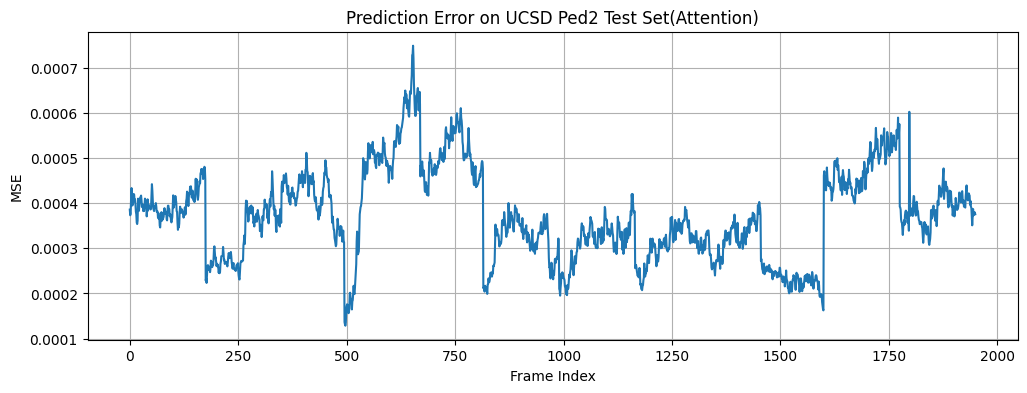

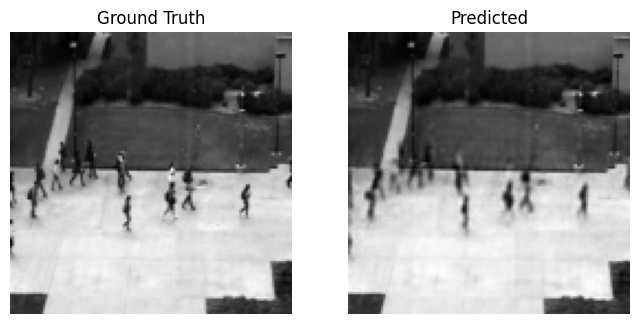

In [19]:
# test attention
attention_model = FutureFramePredictorWithAttention().to(device)
attention_model.load_state_dict(
    torch.load("attention_ucsd_ped2.pth", map_location=device)
)
attention_model.eval()

attention_errors = []

with torch.no_grad():
    for inputs, target in tqdm(test_loader, desc="Testing Attention"):
        inputs = inputs.to(device)
        target = target.to(device)

        pred = attention_model(inputs)
        mse = torch.mean((pred - target) ** 2).item()
        attention_errors.append(mse)

# visualization

import matplotlib.pyplot as plt

# Error curve
plt.figure(figsize=(12,4))
plt.plot(attention_errors)
plt.title("Prediction Error on UCSD Ped2 Test Set(Attention)")
plt.xlabel("Frame Index")
plt.ylabel("MSE")
plt.grid()
plt.show()

# Frame visualization
with torch.no_grad():
    inputs, target = test_dataset[200]
    inputs = inputs.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)

    pred = model(inputs)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Ground Truth")
    plt.imshow(target[0,0].cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Predicted")
    plt.imshow(pred[0,0].cpu(), cmap="gray")
    plt.axis("off")
    plt.show()


In [20]:
# test baseline
class FutureFramePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.convlstm = ConvLSTM(128, 128)
        self.decoder = Decoder()

    def forward(self, x):
        encoded = torch.stack(
            [self.encoder(x[:, t]) for t in range(x.size(1))],
            dim=1
        )
        h = self.convlstm(encoded)
        return self.decoder(h)

        
baseline_model = FutureFramePredictor().to(device)
baseline_model.load_state_dict(
    torch.load("baseline_ucsd_ped2.pth", map_location=device)
)
baseline_model.eval()

baseline_errors = []

with torch.no_grad():
    for inputs, target in tqdm(test_loader, desc="Testing Baseline"):
        inputs = inputs.to(device)
        target = target.to(device)

        pred = baseline_model(inputs)
        mse = torch.mean((pred - target) ** 2).item()
        baseline_errors.append(mse)


Testing Baseline: 100%|████████████████████████████████████████████████████████████| 1950/1950 [03:18<00:00,  9.84it/s]


Aligned GT frames: 1950
Anomalous frames: 1613
Baseline predictions: 1950
Attention predictions: 1950
Baseline AUC (MSE):  0.7141
Attention AUC (MSE): 0.6918


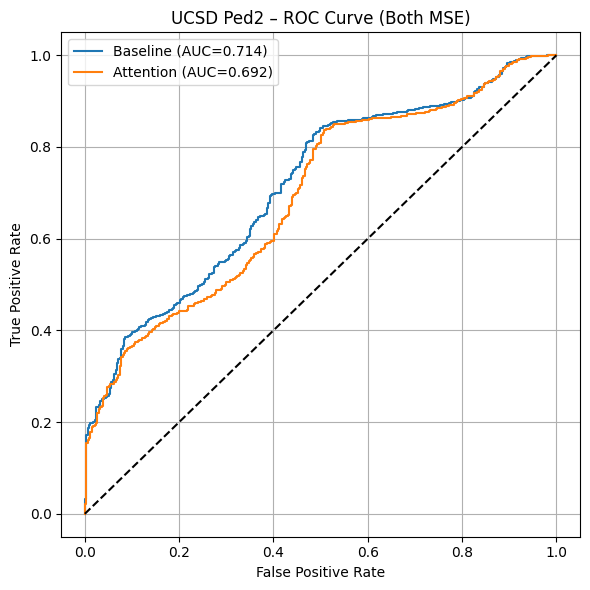

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# ==================================================
# CONFIG
# ==================================================
SEQUENCE_LENGTH = 5   # MUST match dataset & model


# ==================================================
# 1. Load UCSD Ped2 Ground Truth (BMP) – ALIGNED
# ==================================================
def load_ucsd_gt_from_bmp_aligned(gt_root, sequence_length):
    """
    Returns frame-level GT labels aligned with prediction scores.
    Drops the first `sequence_length` frames of each test video.
    """
    gt_labels = []

    test_folders = sorted(os.listdir(gt_root))

    for folder in test_folders:
        folder_path = os.path.join(gt_root, folder)
        if not os.path.isdir(folder_path):
            continue

        frame_files = sorted([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(".bmp")
        ])

        # 🔥 Drop frames without predictions
        frame_files = frame_files[sequence_length:]

        for f in frame_files:
            mask = cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE)
            label = 1 if np.any(mask > 0) else 0
            gt_labels.append(label)

    return np.array(gt_labels)


gt_labels = load_ucsd_gt_from_bmp_aligned(
    "../datasets/UCSDped2/test_gt",
    SEQUENCE_LENGTH
)

print("Aligned GT frames:", len(gt_labels))
print("Anomalous frames:", gt_labels.sum())


# ==================================================
# 2. Sanity checks
# ==================================================
baseline_errors = np.asarray(baseline_errors)
attention_errors = np.asarray(attention_errors)

print("Baseline predictions:", len(baseline_errors))
print("Attention predictions:", len(attention_errors))

assert len(gt_labels) == len(baseline_errors) == len(attention_errors), \
    "GT labels and prediction scores are not aligned!"


# ==================================================
# 3. Normalize scores
# ==================================================
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

baseline_scores = normalize(baseline_errors)
attention_scores = normalize(attention_errors)


# ==================================================
# 4. ROC AUC
# ==================================================
baseline_auc = roc_auc_score(gt_labels, baseline_scores)
attention_auc = roc_auc_score(gt_labels, attention_scores)

print(f"Baseline AUC (MSE):  {baseline_auc:.4f}")
print(f"Attention AUC (MSE): {attention_auc:.4f}")


# ==================================================
# 5. ROC Curve Plot
# ==================================================
fpr_b, tpr_b, _ = roc_curve(gt_labels, baseline_scores)
fpr_a, tpr_a, _ = roc_curve(gt_labels, attention_scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={baseline_auc:.3f})")
plt.plot(fpr_a, tpr_a, label=f"Attention (AUC={attention_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("UCSD Ped2 – ROC Curve (Both MSE)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Testing (Pixel + Feature): 100%|███████████████████████████████████████████████████| 1950/1950 [03:34<00:00,  9.08it/s]



Attention + Feature AUC: 0.7753


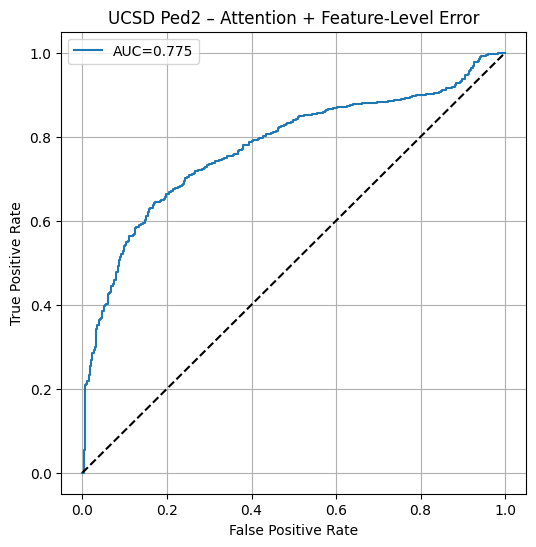

In [24]:
model = FutureFramePredictorWithAttention().to(device)
model.load_state_dict(
    torch.load("attention_ucsd_ped2.pth", map_location=device)
)
model.eval()

alpha = 0.3
beta = 0.7

pixel_errors = []
feature_errors = []
combined_errors = []

with torch.no_grad():
    for inputs, target in tqdm(test_loader, desc="Testing (Pixel + Feature)"):
        inputs = inputs.to(device)
        target = target.to(device)

        pred = model(inputs)

        # Pixel-level error
        pixel_err = torch.mean((pred - target) ** 2)

        # Feature-level error
        feat_pred = model.encoder(pred)
        feat_gt = model.encoder(target)
        feature_err = torch.mean((feat_pred - feat_gt) ** 2)

        score = alpha * pixel_err + beta * feature_err

        pixel_errors.append(pixel_err.item())
        feature_errors.append(feature_err.item())
        combined_errors.append(score.item())


# =====================================================
# NORMALIZE & AUC
# =====================================================
def normalize(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

scores = normalize(combined_errors)

auc = roc_auc_score(gt_labels, scores)
print(f"\nAttention + Feature AUC: {auc:.4f}")


# =====================================================
# ROC CURVE
# =====================================================
fpr, tpr, _ = roc_curve(gt_labels, scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("UCSD Ped2 – Attention + Feature-Level Error")
plt.legend()
plt.grid()
plt.show()


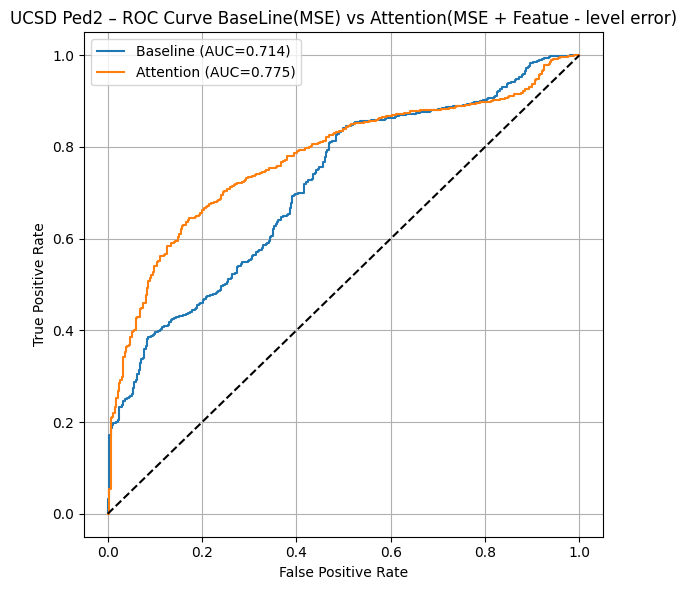

In [28]:
fpr_b, tpr_b, _ = roc_curve(gt_labels, baseline_scores)
fpr_a, tpr_a, _ = roc_curve(gt_labels, scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={baseline_auc:.3f})")
plt.plot(fpr_a, tpr_a, label=f"Attention (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("UCSD Ped2 – ROC Curve BaseLine(MSE) vs Attention(MSE + Featue - level error)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
